# Box Office Data Analysis
## Part 3
#### Data Modelling

This is a notebook is for linear regression modelling. 


### Data Description

- TITLE = Title 
- ADJ_GROSS = Adjusted (2017) total domestic grossing
- LOG_GROSS = Log of ADJ_GROSS
- RELEASE = Release date as datetime object
- AGE = Age as of January 31, 2018 in days
- GENRE = Movie genres as categorical dummy variables:
    - Thriller_Horror 
    - Comedy
    - Documentary
    - Drama 
        - (Drama | Romance)
    - Adventure_Action
        - (Sci-Fi | Fantasy | Adventure | Crime | Western | War | Action)
    - Baseline is all others
        - (Animation | Foreign | Musical | Concert | IMAX | Family | Unknown | Sports | Epic)

- RUNTIME = Runtime in minutes
- RATING = MPAA Rating as categorical dummy variables:
    - Family 
        - G
        - PG
    - PG-13
    - R
    - Baseline is all others 
        - (Unrated, Not Yet Rated, NC-17, Unknown)
- BUDGET = Budget (Unadjusted)
- LOG_BUDGET = Log of BUDGET

In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import pprint as pp
import numpy as np
import patsy

sns.set()
%matplotlib inline
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)

/Users/user/Desktop/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in Pickle file (Rick)
df = pd.read_pickle('data/mojo_jojo_main_cleaned.pickle')
df_budget = pd.read_pickle('data/mojo_jojo_sub.pickle')

In [3]:
# Check the pickled dataframes
print('df normal shape: ', df.shape)
print('df budget shape: ', df_budget.shape, '\n')

df_budget.describe()

df normal shape:  (14131, 16)
df budget shape:  (3041, 18) 



,ADJ_GROSS,AGE_D,BUDGET,RUNTIME,FAMILY,PG13,R,Adventure_Action,Comedy,Documentary,Drama,Thriller_Horror,LOG_GROSS,LOG_BUDGET,AGE_Y,BUDGET2
count,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000,3041.0000
mean,83208008.0566,4509.4850,55322540.1082,108.4416,0.1789,0.3775,0.4226,0.2299,0.3045,0.0092,0.1592,0.1838,17.2338,17.1666,12.3548,17539056260267072.0000
std,108135003.3185,2733.3543,120346314.7412,18.5575,0.3833,0.4848,0.4940,0.4208,0.4603,0.0955,0.3659,0.3874,1.9667,1.3909,7.4886,410833384112818944.0000
min,700.0000,5.0000,220.0000,63.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.5511,5.3936,0.0137,48400.0000
25%,16931900.0000,2413.0000,16000000.0000,95.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6447,16.5881,6.6110,256000000000000.0000
50%,47207800.0000,4417.0000,34000000.0000,105.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.6701,17.3419,12.1014,1156000000000000.0000
75%,105602000.0000,6305.0000,68000000.0000,119.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,18.4752,18.0350,17.2740,4624000000000000.0000
max,1151262600.0000,13823.0000,4663000000.0000,194.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,20.8641,22.2629,37.8712,21743569000000000000.0000


# Part 1: 
## Understanding relationships of the data before we jump into rigorous model selection
Good to go! (งツ)ว

Lets regress! Here is the baseline model:

In [4]:
# Making a simple linear regression against the target variable: Adjusted Gross of a movie
# This is the starting point:
formula = 'ADJ_GROSS ~ 1 + AGE_Y + RUNTIME' # 1 is intercept and not needed

# Creating the X-features and y-target matrices for first-run testing
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

# Model fit with matrices
tinylm = sm.OLS(y, X)
tinyfit = tinylm.fit()

# Model performance summary statisticr
tinyfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ADJ_GROSS   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     521.6
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          2.77e-219
Time:                        19:18:59   Log-Likelihood:            -2.7411e+05
No. Observations:               14131   AIC:                         5.482e+05
Df Residuals:                   14128   BIC:                         5.482e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.323e+07   3.15e+06    -20.097      0.000   -6.94e+07   -5.71e+07
AGE_Y       1.064e+06   5.48e+04     19.437      0.000    9.57e+05    1.17e+06
RUNTIME     7.479e+05   2.91e+04     25.674      0.000    6.91e+05    8.05e+05
==============================================================================
Omnibus:                    13731.580   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           826680.176
Skew:                           4.707   Prob(JB):                         0.00
Kurtosis:                      39.269   Cond. No.                         616.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
# Upgrading our model a bit with ratings
formula = 'ADJ_GROSS ~ 1 + AGE_Y + RUNTIME + FAMILY + PG13 + R'

# Creating the X-features and y-target matrices for first-run testing
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

# Model fit with matrices
rlm = sm.OLS(y, X)
rfit = rlm.fit()

# Model performance summary statistics
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ADJ_GROSS   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     528.0
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:18:59   Log-Likelihood:            -2.7340e+05
No. Observations:               14131   AIC:                         5.468e+05
Df Residuals:                   14125   BIC:                         5.469e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.967e+07   3.04e+06    -26.192      0.000   -8.56e+07   -7.37e+07
AGE_Y       5.345e+05   5.65e+04      9.463      0.000    4.24e+05    6.45e+05
RUNTIME     7.444e+05   2.79e+04     26.666      0.000     6.9e+05    7.99e+05
FAMILY       5.32e+07   1.78e+06     29.861      0.000    4.97e+07    5.67e+07
PG13        4.893e+07   1.54e+06     31.701      0.000    4.59e+07     5.2e+07
R           1.772e+07   1.36e+06     13.012      0.000    1.51e+07    2.04e+07
==============================================================================
Omnibus:                    13671.591   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           900449.124
Skew:                           4.631   Prob(JB):                         0.00
Kurtosis:                      40.994   Cond. No.                         636.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I cannot be confident with this model, as it does not have much power. This is due to the skew of the real variable's distribution. I will make a new baseline with a logged target. The regression of the log transformed dependent variable is attempting to estimate the geometric mean effects of the original variable. It takes into account the compounding nature of our inflationary monetary system (aka printing dirty fiat money), so we change the question we are asking. It is not about predicting the adjusted grossing in real terms, but about the magnitude of each independent variable's effects on the dependent variable. Basically, a 1 unit increase in our independent variable relates to a Beta*100% increase in movie grossing.

In [6]:
# Making a simple linear regression against the target variable, Log Gross of a movie
# This model will be our new baseline:
formula = 'LOG_GROSS ~ 1 + AGE_Y + RUNTIME + FAMILY + PG13 + R'

# Creating the X-features and y-target matrices for first-run testing
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

# Model fit with matrices
baselm = sm.OLS(y, X)
basefit = baselm.fit()

# Model performance summary statistics
basefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LOG_GROSS   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     2355.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:18:59   Log-Likelihood:                -32671.
No. Observations:               14131   AIC:                         6.535e+04
Df Residuals:                   14125   BIC:                         6.540e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4160      0.122     52.794      0.000       6.178       6.654
AGE_Y          0.0815      0.002     36.114      0.000       0.077       0.086
RUNTIME        0.0390      0.001     35.010      0.000       0.037       0.041
FAMILY         4.2856      0.071     60.213      0.000       4.146       4.425
PG13           4.2879      0.062     69.535      0.000       4.167       4.409
R              2.7662      0.054     50.835      0.000       2.660       2.873
==============================================================================
Omnibus:                      331.710   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.972
Skew:                          -0.387   Prob(JB):                     8.29e-78
Kurtosis:                       2.942   Cond. No.                         636.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### **The baseline model is:**

$$
Log\_Gross = \beta_0 + \beta_1Age\_Y + \beta_2Runtime + \beta_3Family + \beta_4PG13 + \beta_5R 
$$

The model significantly explains some variance in the dependent variable, about 45% of the variance of movie's Logged Grossings can be explained by a simple 5-variable model. 3 of which are categorical variables. We have a very high F-statistic, so there is great confidence that the baseline model is somewhat useful for prediction. The model suggests there is not much advantage from focusing on Family vs. PG-13, but we can conclude that R rated movies are less likely to gross more than the family-friendly movies.

In [7]:
# This is the full model using all features.
# Put '- 1' at the end to hack the R^2
formula = 'LOG_GROSS ~ 1 + AGE_Y + RUNTIME + \
                       FAMILY + PG13 + R + \
                       Adventure_Action + Comedy + Documentary + Drama + Thriller_Horror'


# Creating the X and y for first run testing
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

# Model fit with matrices
lmfull = sm.OLS(y, X)
fullfit = lmfull.fit()

# Model performance summary statistics
fullfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LOG_GROSS   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1439.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:18:59   Log-Likelihood:                -31990.
No. Observations:               14131   AIC:                         6.400e+04
Df Residuals:                   14120   BIC:                         6.409e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.0397      0.128     47.032      0.000       5.788       6.291
AGE_Y                0.0896      0.002     40.212      0.000       0.085       0.094
RUNTIME              0.0378      0.001     34.064      0.000       0.036       0.040
FAMILY               3.8524      0.070     55.086      0.000       3.715       3.990
PG13                 3.5134      0.064     55.019      0.000       3.388       3.639
R                    2.0344      0.057     35.584      0.000       1.922       2.147
Adventure_Action     1.8961      0.072     26.467      0.000       1.756       2.036
Comedy               1.5998      0.059     27.277      0.000       1.485       1.715
Documentary          0.1718      0.073      2.350      0.019       0.028       0.315
Drama                0.5198      0.064      8.069      0.000       0.393       0.646
Thriller_Horror      1.9176      0.074     26.079      0.000       1.773       2.062
==============================================================================
Omnibus:                      436.620   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              487.074
Skew:                          -0.420   Prob(JB):                    1.71e-106
Kurtosis:                       3.348   Cond. No.                         742.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I considered dropping the documentary genre from the model because it did not provide additional information, I looked into the data and found outliers that were contributing to this. After cleaning the runtime outliers, the variable seems significant enough (~0.02 p-value) to keep, considering it does not drop the R-square adjusted score. The Full model is less significant than the subset model even though F-stats are very high: **
 - Full model significance: F-stat = 1439
 - Reduced model significance: F-stat = 1598 (No documentary genre variable)
 
Using all of the variables gets us up to ~50% R-squared. It is nice to see a low condition number, as it confirms there is no multicollinearity (there theoretically should not be any).

In [8]:
# This is using formula.api, nearly identical to the method above
# This model is on the smaller budget-included subset
# One variable starter
formulaB = 'LOG_GROSS ~ np.log(BUDGET)'
lmB = smf.ols(formulaB, data=df_budget).fit()

# Model performance summary statistics
lmB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LOG_GROSS   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1533.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          8.39e-272
Time:                        19:18:59   Log-Likelihood:                -5750.3
No. Observations:                3041   AIC:                         1.150e+04
Df Residuals:                    3039   BIC:                         1.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.1794      0.360      8.827      0.000       2.473       3.886
np.log(BUDGET)     0.8187      0.021     39.149      0.000       0.778       0.860
==============================================================================
Omnibus:                      796.859   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2531.600
Skew:                          -1.317   Prob(JB):                         0.00
Kurtosis:                       6.612   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

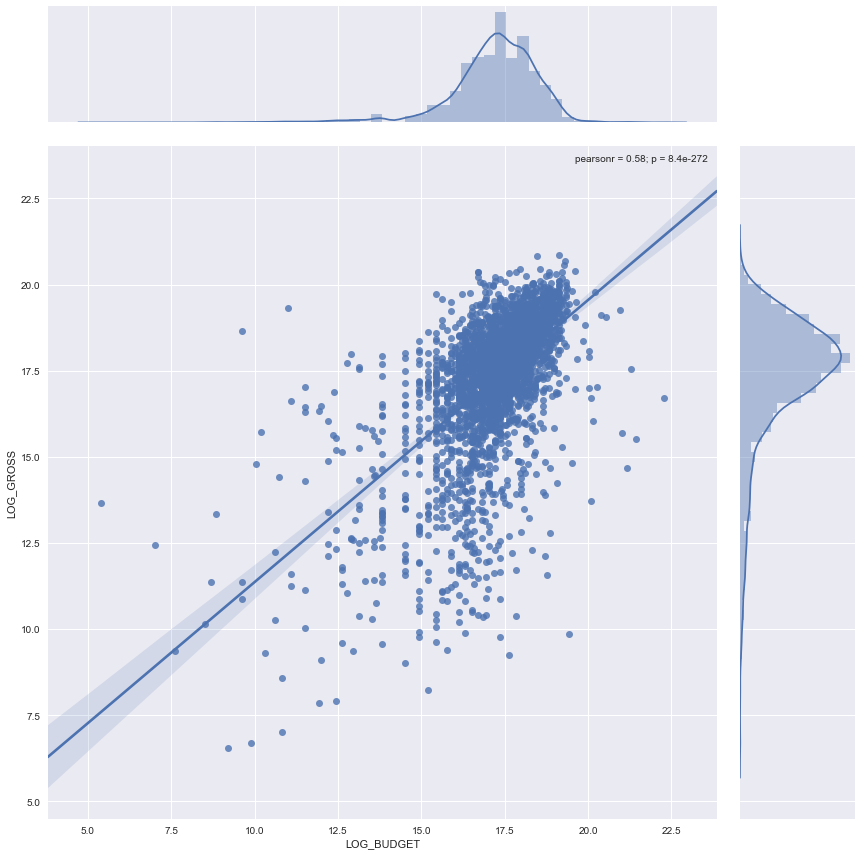

In [9]:
# Showing the log-log relationship between Gross and Budget. Nice linear relationship
fig = sns.jointplot("LOG_BUDGET", "LOG_GROSS", kind="regplot", data=df_budget, size=12)

In [10]:
# This model is on the smaller budget-included subset with all features
formulaB = 'LOG_GROSS ~ 1 + RUNTIME + AGE_Y + np.log(BUDGET) + \
                        FAMILY + PG13 + R + \
                        Adventure_Action + Comedy + Documentary + Drama + Thriller_Horror'
lmB1 = smf.ols(formulaB, data=df_budget).fit()

# Model performance summary statistics
lmB1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LOG_GROSS   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     221.8
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:19:00   Log-Likelihood:                -5472.8
No. Observations:                3041   AIC:                         1.097e+04
Df Residuals:                    3029   BIC:                         1.104e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0662      0.390      2.736      0.006       0.302       1.830
RUNTIME              0.0137      0.002      8.095      0.000       0.010       0.017
AGE_Y                0.0187      0.004      5.155      0.000       0.012       0.026
np.log(BUDGET)       0.6223      0.023     27.268      0.000       0.578       0.667
FAMILY               3.7418      0.206     18.151      0.000       3.338       4.146
PG13                 3.1826      0.200     15.890      0.000       2.790       3.575
R                    2.6507      0.197     13.478      0.000       2.265       3.036
Adventure_Action     0.8295      0.105      7.884      0.000       0.623       1.036
Comedy               1.0412      0.099     10.531      0.000       0.847       1.235
Documentary          0.9645      0.297      3.251      0.001       0.383       1.546
Drama                0.2604      0.112      2.318      0.021       0.040       0.481
Thriller_Horror      1.1929      0.111     10.782      0.000       0.976       1.410
==============================================================================
Omnibus:                      686.636   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2014.760
Skew:                          -1.162   Prob(JB):                         0.00
Kurtosis:                       6.241   Cond. No.                     1.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The subset of data with budget information was not more predictive than our full model with a ~45% R-squared value, and it comes with a more complex interpretation. I would like to use this model but we do not have sufficient data/ data cleaning to produce the best result. The interesting piece to conclude from this is that logged budgets were very significant in explaining logged grossings and a 1% increase in budget leads to a 62% increase in movie gross, ceteris paribus. I expect that this would be a good base to compare with more complex models that include interaction terms and polynomial features. The single variable model did amount to 1/3 of the variance explained. Also, I am suggesting the predictor and target to have an inelastic relationship: increasing the budget by 1%, and considering the other variables constant, would increase the gross by .62%. If we consider a popular movie like Forrest Gump, the movie budget was \$55 million- increasing the budget 1% or \$550,000 would result in an expected increase in grossing by \$866,620. Confirmation shown below (1.01^0.6223 = 1.0062)

In [11]:
# Interpret the increase in predicted gross when increasing budget by 1%
test1 = df_budget[(df_budget.TITLE == 'Forrest Gump')]
test2 = test1.copy()

print("Forrest Gump's budget: ", test1.BUDGET.values)
one_pct = 0.01
new_budget = test1.BUDGET.values[0] * one_pct

test2.loc[test2.index[0], 'BUDGET'] += new_budget
test2.loc[test2.index[0], 'LOG_BUDGET'] = np.log(test2.BUDGET.values[0])

pred1 = np.exp(lmB1.predict(exog = test1))
pred2 = np.exp(lmB1.predict(exog = test2))
increase = pred2-pred1
increase_pct = ((pred2 / pred1))

print("Predicted gross for Forrest Gump: ", pred1.values)
print("Predicted gross with 1% budget increase: ", pred2.values)
print("Difference: ", increase.values)
print("Percent increase: ", increase_pct.values)

Forrest Gump's budget:  [55000000.0000]
Predicted gross for Forrest Gump:  [139512399.8151]
Predicted gross with 1% budget increase:  [140379020.6083]
Difference:  [866620.7932]
Percent increase:  [1.0062]


In [12]:
# Diagnostic tests
# Creating a column for predictions and residuals
df['PRED']=fullfit.predict(X)
df['RESID']=df.LOG_GROSS - df.PRED

df.RESID.describe()

count   14131.0000
mean       -0.0000
std         2.3278
min        -9.7557
25%        -1.4402
50%         0.2153
75%         1.6357
max         9.4885
Name: RESID, dtype: float64

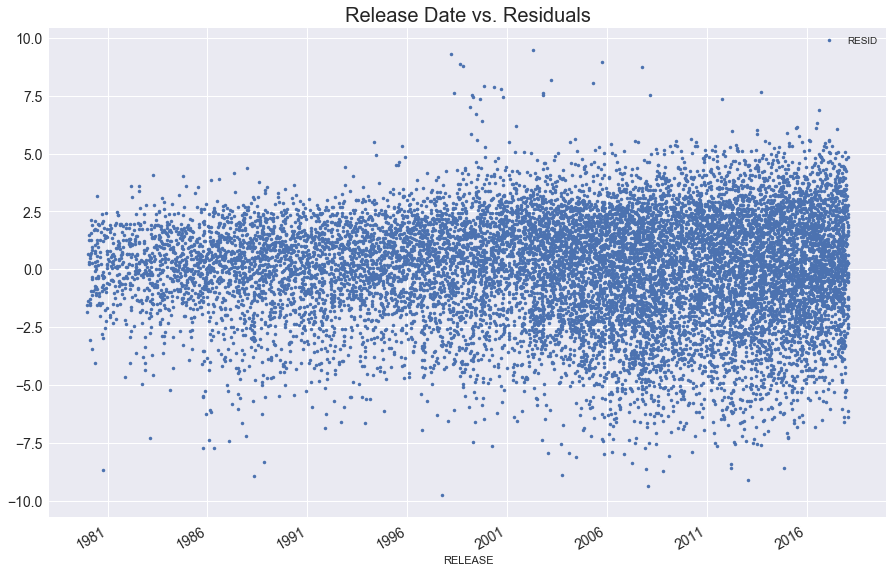

In [13]:
# New dataframe for plotting residuals against our time series
ts_resid = df[['RELEASE', 'RESID']].set_index('RELEASE')
ts = ts_resid.plot(style=".", figsize = (15,10), title='Release Date vs. Residuals', fontsize=(14))
ts.title.set_size(20)

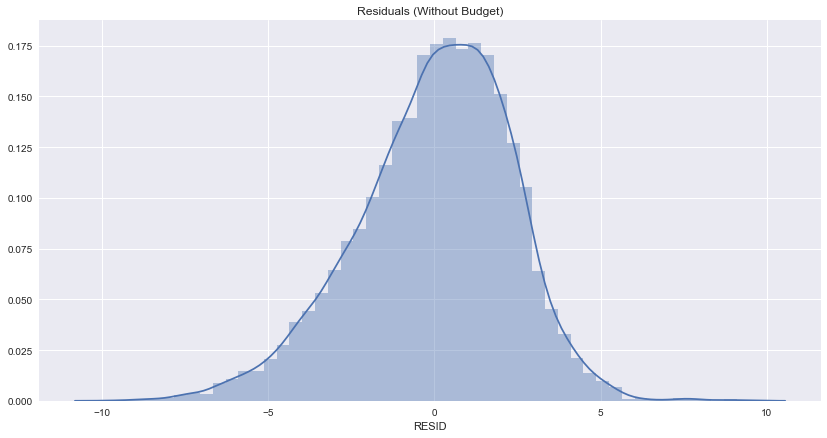

In [14]:
# Some heteroskedasticity above
# Fitting a residual plot for the baseline regression
fig = plt.subplot(1, 1, 1)
fig = sns.distplot(df.RESID, kde=True)
fig = plt.title('Residuals (Without Budget)')
fig.figure.set_size_inches(14,7)

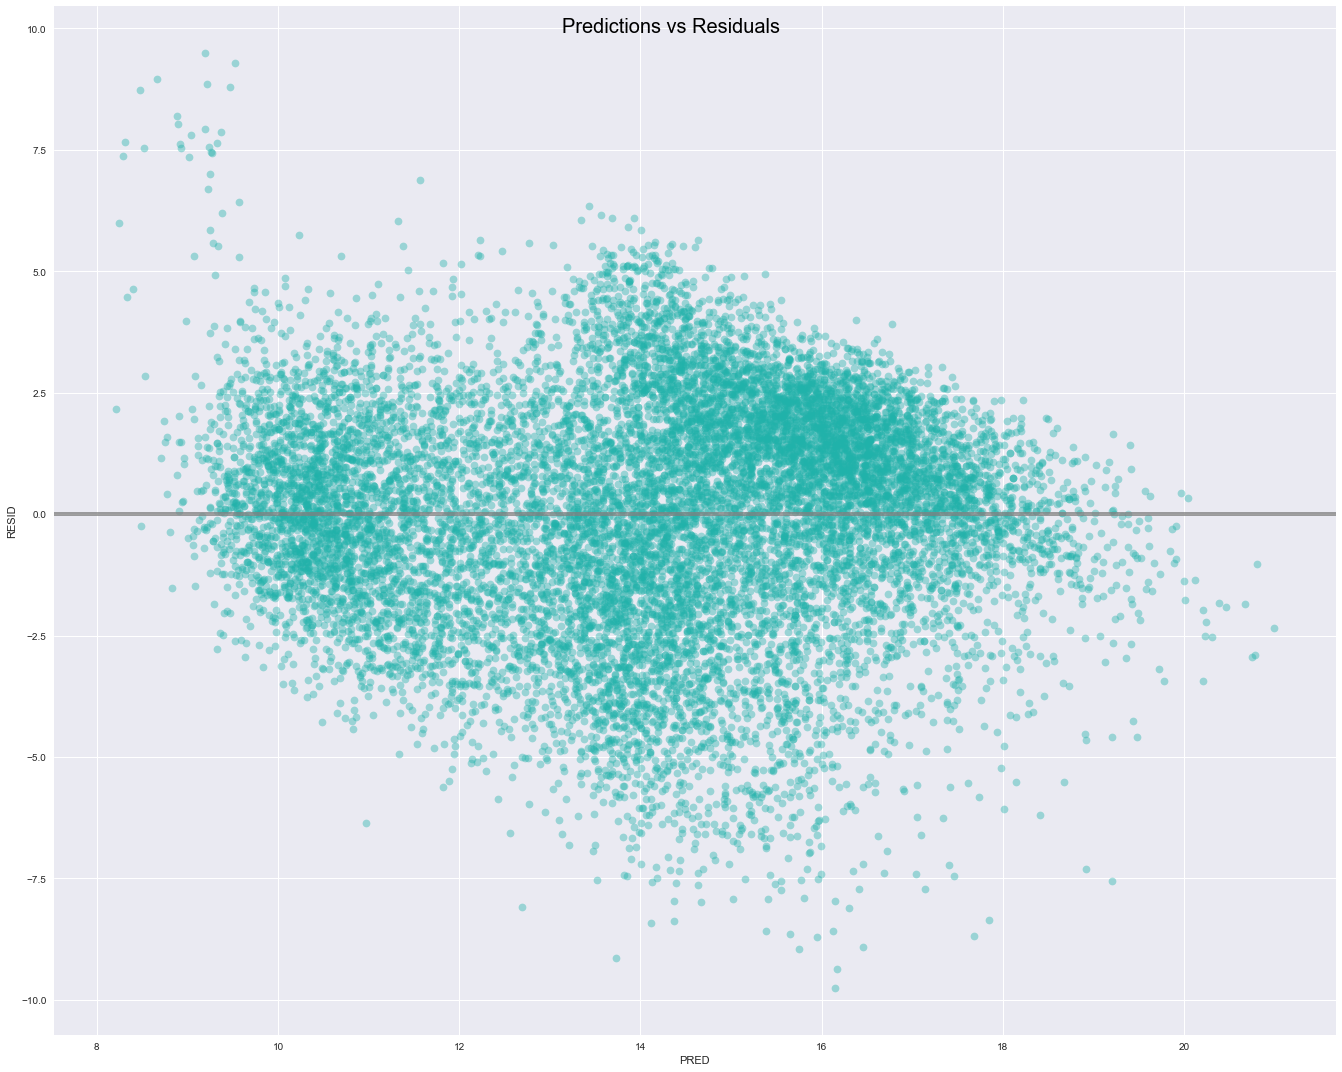

In [15]:
# Predicted values vs. Residual values plot
fig2 = sns.lmplot(data=df, x='PRED', y='RESID', ci=True, size=15, aspect=1.25,
                   scatter_kws={"color": "lightseagreen", "alpha": 0.4, "s": 60},
                   line_kws={"color": "grey", "alpha": 0.75, "lw": 4})
fig2.fig.suptitle('Predictions vs Residuals', fontsize=20, color="k", alpha=1)

In [16]:
# Looking at those  outliers on the top left
df[(df.PRED < 9) & (df.RESID > 7.5)]

,ADJ_GROSS,AGE_D,RELEASE,RUNTIME,TITLE,FAMILY,PG13,R,Adventure_Action,Comedy,Documentary,Drama,Thriller_Horror,LOG_GROSS,AGE_Y,AGE_Y2,PRED,RESID
282,22356100.0000,4681.0000,2005-04-08,45.0000,Wild Safari 3D,0,0,0,0,0,0,0,0,16.9226,12.8247,164.4718,8.8897,8.0329
4983,29718800.0000,3771.0000,2007-10-05,40.0000,Sea Monsters: A Prehistoric Adventure,0,0,0,0,0,0,0,0,17.2073,10.3315,106.7400,8.4774,8.7299
5667,14050700.0000,5591.0000,2002-10-11,40.0000,Pulse: A Stomp Odyssey,0,0,0,0,0,0,0,0,16.4582,15.3178,234.6352,8.9240,7.5342
7468,44561600.0000,4513.0000,2005-09-23,40.0000,Magnificent Desolation,0,0,0,0,0,0,0,0,17.6124,12.3644,152.8780,8.6595,8.9529
8533,8574400.0000,1601.0000,2013-09-13,45.0000,Jerusalem,0,0,0,0,0,1,0,0,15.9643,4.3863,19.2396,8.3058,7.6585
10991,9465200.0000,3638.0000,2008-02-15,42.0000,Dolphins and Whales: Tribes of the Ocean 3D,0,0,0,0,0,0,0,0,16.0631,9.9671,99.3435,8.5204,7.5427
12192,26448600.0000,5439.0000,2003-03-12,40.0000,Bugs!,0,0,0,0,0,0,0,0,17.0907,14.9014,222.0508,8.8867,8.2041
13615,15315800.0000,5584.0000,2002-10-18,40.0000,Adrenaline Rush: The Science of Risk,0,0,0,0,0,0,0,0,16.5444,15.2986,234.0481,8.9222,7.6222


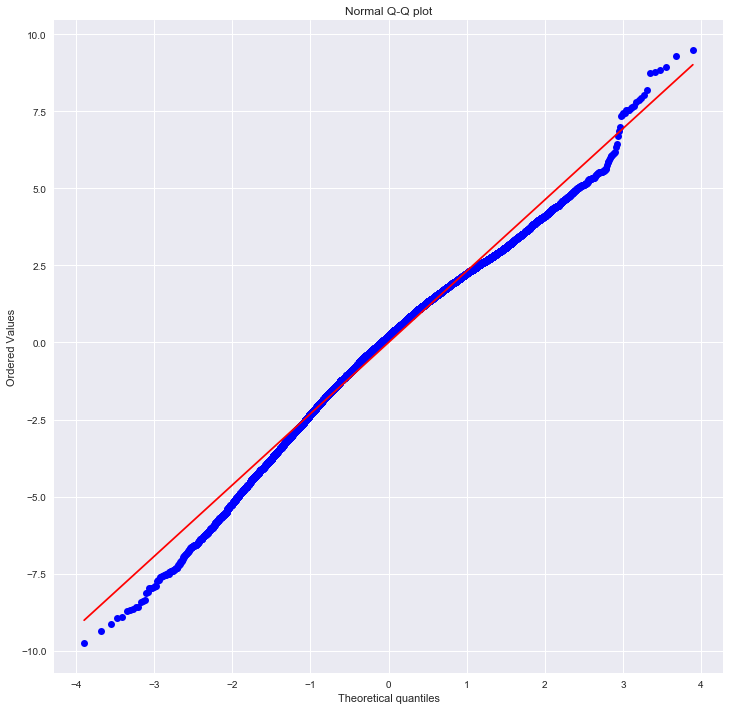

In [17]:
# Quantile-Quantile Ptot
fig3 = plt.figure(figsize=(12,12))
fig3 = stats.probplot(fullfit.resid, dist='norm', plot=plt)
fig3 = plt.title("Normal Q-Q plot")

** Our diagnostics testing on our simple linear regression looks good. There is no autocorrelation and the residuals mean is 0 and normally distributed, with a left tail and some kurtosis. Now for part 2. **


# Part 2: 
## Rigorous model selection and improvement

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

/Users/user/Desktop/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# Dropping unneccessary columns and viewing our data columns again
df_model = df.drop(['AGE_D', 'TITLE', 'PRED', 'RESID', 'RELEASE', 'ADJ_GROSS', 'AGE_Y2'], axis = 1, inplace = False)

print(df_model.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14131 entries, 0 to 14130
Data columns (total 11 columns):
RUNTIME             14131 non-null float64
FAMILY              14131 non-null uint8
PG13                14131 non-null uint8
R                   14131 non-null uint8
Adventure_Action    14131 non-null uint8
Comedy              14131 non-null uint8
Documentary         14131 non-null uint8
Drama               14131 non-null uint8
Thriller_Horror     14131 non-null uint8
LOG_GROSS           14131 non-null float64
AGE_Y               14131 non-null float64
dtypes: float64(3), uint8(8)
memory usage: 441.7 KB
None


In [20]:
# Model predictor variables
X = df_model.loc[:, ['AGE_Y', 'RUNTIME', 'FAMILY', 'PG13', 'R', 'Adventure_Action', 
                    'Comedy', 'Documentary', 'Drama', 'Thriller_Horror']]

# Model target, predicting the log of movie grosses
y = df_model.LOG_GROSS

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.30)

In [21]:
# Baseline model
lm = LinearRegression()
lm.fit(X_train, y_train)
print('OLS regression score val R^2: %.3f' % lm.score(X_val, y_val))
print("\nBaseline Coefficients: \n Intercept, ", lm.intercept_)
pp.pprint(list(zip(X.columns, lm.coef_)))
print('\n')

# Parameters for poly models
interactions = PolynomialFeatures(degree=2, interaction_only=True)
polynomials = PolynomialFeatures(degree=2, interaction_only=False)
interactions3 = PolynomialFeatures(degree=3, interaction_only=True)
polynomials3 = PolynomialFeatures(degree=3, interaction_only=False)

# Interactions between features
lm.fit(interactions.fit_transform(X_train), y_train)
print('OLS regression with interaction terms val R^2: %.3f' % lm.score(interactions.transform(X_val), y_val))
lm.fit(interactions3.fit_transform(X_train), y_train)
print('OLS regression with interaction3 terms val R^2: %.3f' % lm.score(interactions3.transform(X_val), y_val))

# Polynomials of features
lm.fit(polynomials.fit_transform(X_train), y_train)
print('OLS regression with polynomial terms val R^2: %.3f' % lm.score(polynomials.transform(X_val), y_val))
lm.fit(polynomials3.fit_transform(X_train), y_train)
print('OLS regression with polynomial3 terms val R^2: %.3f' % lm.score(polynomials3.transform(X_val), y_val))

# Random Forest model
rf = RandomForestRegressor(n_estimators=1500, max_features=3)
rf.fit(X_train, y_train)
print("Random Forest R^2: %.3f" % rf.score(X_val, y_val))

# Gradient Boosting
gbm = GradientBoostingRegressor(n_estimators=1500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
print("Gradient Boosting R^2: %.3f" % gbm.score(X_val, y_val))

OLS regression score val R^2: 0.512

Baseline Coefficients: 
 Intercept,  6.077051462483183
[('AGE_Y', 0.09189054973242367),
 ('RUNTIME', 0.037305780263480415),
 ('FAMILY', 3.7664763900760923),
 ('PG13', 3.452995462554852),
 ('R', 1.995682926835868),
 ('Adventure_Action', 1.904556283916107),
 ('Comedy', 1.6465220661532132),
 ('Documentary', 0.12476469406319357),
 ('Drama', 0.5669673337658002),
 ('Thriller_Horror', 1.950210354954937)]


OLS regression with interaction terms val R^2: 0.565
OLS regression with interaction3 terms val R^2: 0.570
OLS regression with polynomial terms val R^2: 0.568
OLS regression with polynomial3 terms val R^2: 0.585
Random Forest R^2: 0.518
Gradient Boosting R^2: 0.568


The complexity provides small gains, but there should not be any interaction within genres or ratings.
The baseline model is a match to the result found earlier without validation, which is a good sign. I choose the simple linear regression as my full model for interpretablility and performance.
##### **The final model is:**

$$
Log\_Gross = \beta_0 + \beta_1Age\_Y + \beta_2Runtime + \beta_3Family + \beta_4PG13 + \beta_5R + \beta_6Adventure\_Action + \beta_7Comedy + \beta_8Documentary + \beta_9Drama + \beta_T Thriller\_Horror
$$


Now for K-Fold cross-validation with simple and LASSO regression, this will help select the best features for our final proposal.

Minimum value in our test error vector: 5.2899
The best alpha associated with this model: 0.0100


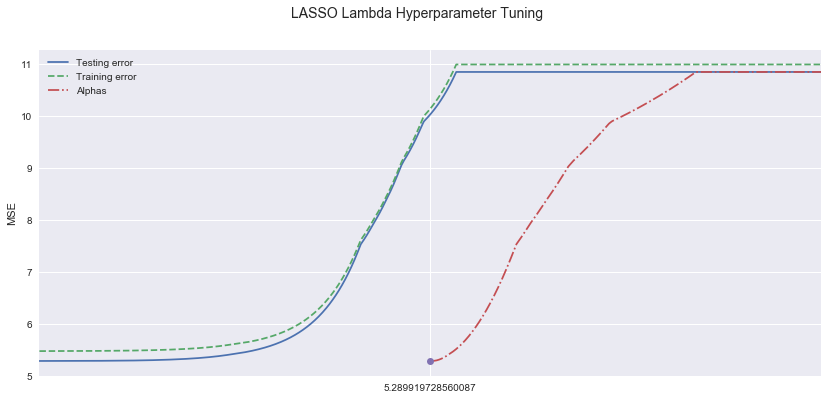

In [22]:
# First finding the right lambda level

# Set test alpha vector and the error space that will plot the error score for each alpha
alpha_vec = 10**np.linspace(-2,2,1000)
err_vec_test = np.zeros(len(alpha_vec))
err_vec_train = np.zeros(len(alpha_vec))

for i, curr_alpha in enumerate(alpha_vec):
    steps = [('standardize', StandardScaler()), ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    test_set_pred_LASSO = pipe.predict(X_val)
    err_vec_test[i] = np.mean((test_set_pred_LASSO - y_val)**2)

    train_set_pred_LASSO = pipe.predict(X_train)
    err_vec_train[i] = np.mean((train_set_pred_LASSO - y_train)**2)
    
#plot the curves of both the training error and test error as alpha changes
plt.figure(figsize=(14,6))
locs, labels = plt.xticks()
plt.plot(np.log10(alpha_vec),err_vec_test)

plt.plot(np.log10(alpha_vec),err_vec_train, '--')
plt.plot(alpha_vec,err_vec_test, '-.')
plt.plot(np.min(err_vec_test), "o")
plt.legend(['Testing error', 'Training error', 'Alphas'])
plt.xticks(np.arange(1), err_vec_test)
plt.xlim(min(np.log10(alpha_vec)), max(np.log10(alpha_vec)))
plt.ylabel('MSE')
plt.suptitle('LASSO Lambda Hyperparameter Tuning', fontsize=14, ha='center')

opt_alpha = alpha_vec[np.argmin(err_vec_test)]

print('Minimum value in our test error vector: %.4f' % np.min(err_vec_test))
print('The best alpha associated with this model: %.4f' % opt_alpha)

In [23]:
# Model predictor variables
X = df_model.loc[:, ['AGE_Y', 'RUNTIME', 'FAMILY', 'PG13', 'R', 'Adventure_Action', 
                    'Comedy', 'Documentary', 'Drama', 'Thriller_Horror']]

# Model target, predicting the log of movie grosses
y = df_model.LOG_GROSS

# This helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

# Hold out 20% of the data for final testing, set folds
X, x_val, y, y_val = train_test_split(X, y, test_size=.3, random_state=10) 
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

# Collect the validation results for both models
cv_lm_r2s, cv_lm_las_r2s = [], [] 

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    # Simple linear regression
    lm = LinearRegression()
    lm_las = Lasso(alpha = opt_alpha)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    # Lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_r2s.append(lm_las.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Lasso scores: ', cv_lm_las_r2s, '\n')

print('Simple mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Lasso mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_las_r2s),np.std(cv_lm_las_r2s)))

Simple regression scores:  [0.5132199809740494, 0.5077798829634284, 0.4903690939274377, 0.5149878400203111, 0.4707988968823708]
Lasso scores:  [0.5129765403550979, 0.507739100993494, 0.48988222578920937, 0.5140592784956226, 0.47139024119906187] 

Simple mean cv r^2: 0.499 +- 0.017
Lasso mean cv r^2: 0.499 +- 0.016


In [24]:
# Double checking scaled Lasso results
X = df_model.loc[:, ['AGE_Y', 'RUNTIME', 'FAMILY', 'PG13', 'R', 'Adventure_Action', 
                    'Comedy', 'Documentary', 'Drama', 'Thriller_Horror']]
y = df_model.LOG_GROSS
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# Apply a fitted scaler to X values to normalize for Lasso
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_val)
    
# Tune lambda hyperparameter
alphavector = 10**np.linspace(-2.5,2.5,10000)
lasso_rcv = LassoCV(alphas = alpha_vec, cv=10)
lasso_rcv.fit(X_tr,y_train)
print('Optimal alpha:', lasso_rcv.alpha_)

lasso_prediction_cv = lasso_rcv.predict(X_te)
print("Score:", r2_score(y_val, lasso_prediction_cv))

list(zip(X_train.columns,lasso_rcv.coef_))

Optimal alpha: 0.01
Score: 0.49499195519360073


[('AGE_Y', 0.8774163288486309),
 ('RUNTIME', 0.6840801950882834),
 ('FAMILY', 1.32600217792157),
 ('PG13', 1.3949739849823377),
 ('R', 0.9871309814966419),
 ('Adventure_Action', 0.5938071246600708),
 ('Comedy', 0.6443790940961402),
 ('Documentary', 0.03614944484314232),
 ('Drama', 0.16279111534897575),
 ('Thriller_Horror', 0.57706339271852)]

According to my cross-validated lasso model, a PG-13 Comedy would be best for a movie studio's next production. I would use this model in conjuction with the simple linear regression model above to help predict a movie grossing.

R-Score: 0.495 


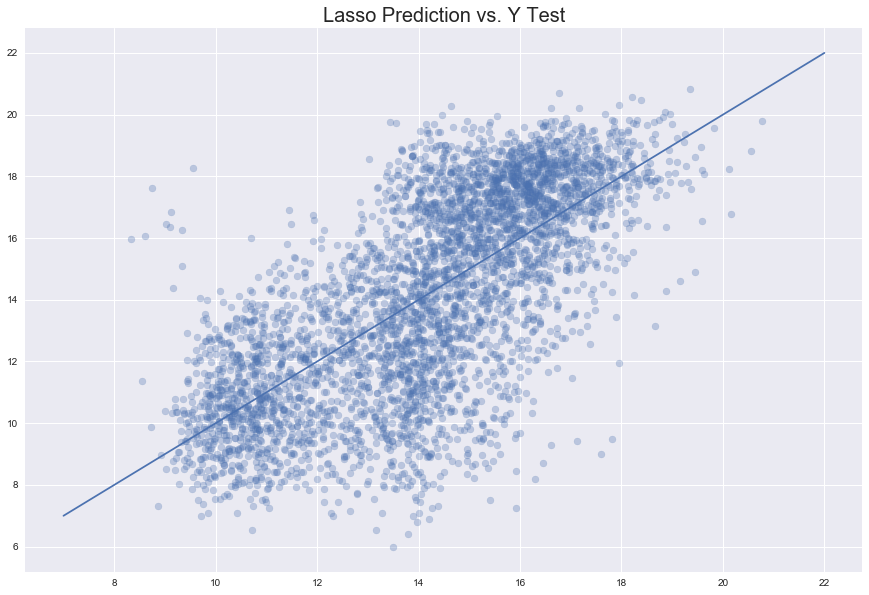

In [25]:
# Plot of Lasso performance
plt.figure(figsize=(15,10))
plt.scatter(lasso_prediction_cv, y_val, alpha=.3)
plt.plot(np.linspace(7,22,100),np.linspace(7,22,100))
plt.title('Lasso Prediction vs. Y Test', fontsize = 20 )

print("R-Score: %.3f "% r2_score(y_val, lasso_prediction_cv))

In [26]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso', verbose=True)

Computing regularization path using the LARS ...
.

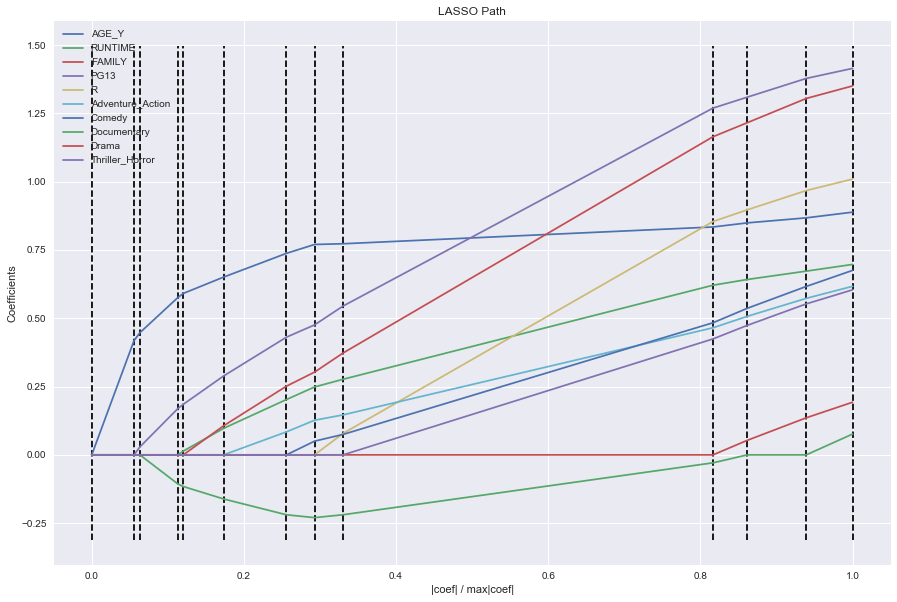

In [27]:
# LARS Path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()